# Linearly decoded VAE

This notebook shows how to use the 'linearly decoded VAE' model which explicitly links latent variables of cells to genes.

The scVI package learns low-dimensional latent representations of cells which get mapped to parameters of probability distributions which can generate counts consistent to what is observed from data. In the standard `VAE` model of scVI these parameters for each gene and cell arise from applying neural networks to the latent variables. Neural networks are flexible and can represent non-linearities in the data. This comes at a price, there is no direct link between a latent variable dimension and any potential set of genes which would covary across it.

The `LDVAE` model replaces the neural networks with linear functions. Now a higher value along a latent dimension will directly correspond to higher expression of the genes with high weights assigned to that dimension.

This leads to a generative model comparable to probabilistic PCA or factor analysis, but generates counts rather than real numbers. Using the framework of scVI also allows variational inference which scales to very large datasets and can make use of GPUs for additional speed.

This notebook demonstrates how to fit an `LDVAE` model to scRNA-seq data, plot the latent variables, and interpret which genes are linked to latent variables.

As an example, we use the PBMC 10K from 10x Genomics.

In [1]:
import sys

#if branch is stable, will install via pypi, else will install from source
branch = "stable"
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and branch == "stable":
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and branch != "stable":
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@$branch#egg=scvi-tools[tutorials]

In [2]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scvi

%matplotlib inline

## Initialization
Load data and select the top 1000 variable genes with seurat_v3 method

In [3]:
save_path = 'data'
adata = sc.read(os.path.join(save_path, "pbmc_10k_protein_v3.h5ad"), backup_url="https://github.com/YosefLab/scVI-data/raw/master/pbmc_10k_protein_v3.h5ad?raw=true")

adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

sc.pp.highly_variable_genes(adata, flavor='seurat_v3', layer='counts', n_top_genes=1000, subset=True)

/home/galen/.pyenv/versions/scvi-dev/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/galen/.pyenv/versions/scvi-dev/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


## Create and fit `LDVAE` model

First subsample 1,000 genes from the original data.

Then we initialize an `LinearSCVI` model. Here we set the latent space to have 10 dimensions.

In [4]:
# setup the anndata for scvi-tools
scvi.data.setup_anndata(adata, layer="counts")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 6855 cells, 1000 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/home/galen/.pyenv/versions/scvi-dev/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [5]:
# initialize LinearSCVI model
model = scvi.model.LinearSCVI(adata, n_latent=10)

In [6]:
# train for 250 epochs, compute metrics every 10 epochs
model.train(max_epochs=250, plan_kwargs={'lr':5e-3}, check_val_every_n_epoch=10)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 250/250: 100%|██████████| 250/250 [01:23<00:00,  2.99it/s, loss=377, v_num=1]


Inspecting the convergence

In [16]:
train_elbo = model.history['elbo_train'][1:]
test_elbo = model.history['elbo_validation']

<AxesSubplot:xlabel='epoch'>

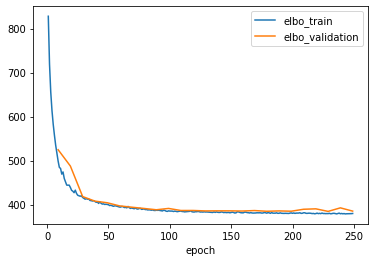

In [17]:
ax = train_elbo.plot()
test_elbo.plot(ax = ax)

## Extract and plot latent dimensions for cells

From the fitted model we extract the (mean) values for the latent dimensions. We store the values in the AnnData object for convenience.

In [18]:
Z_hat = model.get_latent_representation()
for i, z in enumerate(Z_hat.T):
    adata.obs[f'Z_{i}'] = z

Now we can plot the latent dimension coordinates for each cell. A quick (albeit not complete) way to view these is to make a series of 2D scatter plots that cover all the dimensions. Since we are representing the cells by 10 dimensions, this leads to 5 scatter plots.

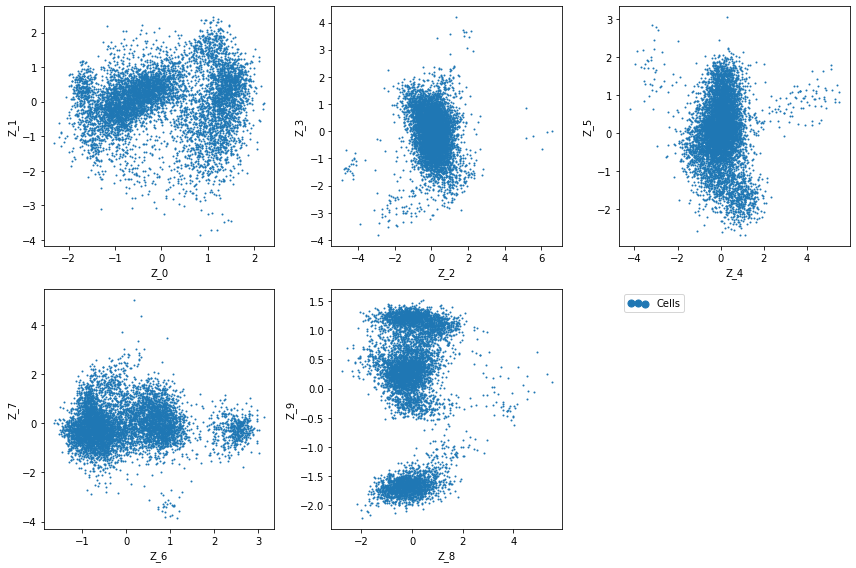

In [19]:
fig = plt.figure(figsize=(12, 8))

for f in range(0, 9, 2):
    plt.subplot(2, 3, int(f / 2) + 1)

    plt.scatter(adata.obs[f'Z_{f}'], adata.obs[f'Z_{f + 1}'], marker='.', s=4, label='Cells')

    plt.xlabel(f'Z_{f}')
    plt.ylabel(f'Z_{f + 1}')

plt.subplot(2, 3, 6)    
plt.scatter(adata.obs[f'Z_{f}'], adata.obs[f'Z_{f + 1}'], marker='.', label='Cells', s=4)
plt.scatter(adata.obs[f'Z_{f}'], adata.obs[f'Z_{f + 1}'], c='w', label=None)
plt.gca().set_frame_on(False)
plt.gca().axis('off')

lgd = plt.legend(scatterpoints=3, loc='upper left')
for handle in lgd.legendHandles:
    handle.set_sizes([200])


plt.tight_layout()

The question now is how does the latent dimensions link to genes?

For a given cell x, the expression of the gene g is proportional to x_g = w_(1, g) * z_1 + ... + w_(10, g) * z_10. Moving from low values to high values in z_1 will mostly affect expression of genes with large w_(1, :) weights. We can extract these weights from the `LDVAE` model, and identify which genes have high weights for each latent dimension.

In [20]:
loadings = model.get_loadings()
loadings.head()

,Z_0,Z_1,Z_2,Z_3,Z_4,Z_5,Z_6,Z_7,Z_8,Z_9
index,,,,,,,,,,
AL645608.8,0.725123,-0.244905,-0.413930,-0.118936,0.750275,0.273040,-0.029361,-0.264088,-0.284976,-0.285616
HES4,0.492943,-0.156216,0.227400,-0.496830,0.617575,0.116129,0.089952,-0.270402,-0.107262,-0.314618
ISG15,0.770460,-0.127998,-0.176990,-0.265530,0.079138,0.029638,0.091805,-0.113080,-0.398648,0.464324
TNFRSF18,1.006157,-0.758205,0.099908,-0.328675,-0.209682,-0.601143,0.027755,-0.719139,0.023059,1.608894
TNFRSF4,1.666025,-0.685751,-0.016991,-0.342675,-0.303753,-0.469472,0.073631,-0.478701,-0.249382,1.220628


For every latent variable Z, we extract the genes with largest _magnitude_, and separate genes with large negative values from genes with large positive values. We print out the top 5 genes in each direction for each latent variable.

In [21]:
print('Top loadings by magnitude\n---------------------------------------------------------------------------------------')
for clmn_ in loadings:
    loading_ = loadings[clmn_].sort_values()
    fstr = clmn_ + ':\t'
    fstr += '\t'.join([f'{i}, {loading_[i]:.2}' for i in loading_.head(5).index])
    fstr += '\n\t...\n\t'
    fstr += '\t'.join([f'{i}, {loading_[i]:.2}' for i in loading_.tail(5).index])
    print(fstr + '\n---------------------------------------------------------------------------------------\n')

Top loadings by magnitude
---------------------------------------------------------------------------------------
Z_0:	FCRL5, -0.95	HLA-DQA1, -0.9	HLA-DQA2, -0.81	CCL3, -0.75	PDLIM1, -0.7
	...
	LRRN3, 2.1	IL7R, 2.2	MAL, 2.2	TSHZ2, 2.3	CD40LG, 2.3
---------------------------------------------------------------------------------------

Z_1:	IFI27, -1.3	TWIST1, -1.1	DUSP4, -1.0	LINC02195, -0.95	ZBTB32, -0.88
	...
	LCNL1, 1.1	S100B, 1.2	CD8A, 1.2	CD8B, 1.4	LINC02446, 1.7
---------------------------------------------------------------------------------------

Z_2:	ANKRD53, -0.74	CD207, -0.66	LILRA4, -0.61	NMU, -0.58	AR, -0.57
	...
	GNAZ, 0.99	TUBB1, 1.0	CMTM5, 1.0	SH3BGRL2, 1.0	ITGA2B, 1.1
---------------------------------------------------------------------------------------

Z_3:	C1QB, -1.6	C1QA, -1.6	C1QC, -1.6	ENHO, -1.4	FPR3, -1.4
	...
	IGHG3, 0.73	IGHG2, 0.73	SHISA8, 0.76	IGHG1, 0.81	IGLV1-51, 1.0
---------------------------------------------------------------------------------------


It is important to keep in mind that unlike traditional PCA, these latent variables are not ordered. Z_0 does not necessarily explain more variance than Z_1.

These top genes can be interpreted as following most of the structural variation in the data.

The `LinearSCVI` model further supports the same scVI functionality as the `SCVI` model, so all posterior methods work the same. Here we show how to use scanpy to visualize the latent space.

In [22]:
adata.obsm["X_scVI"] = Z_hat
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.8)

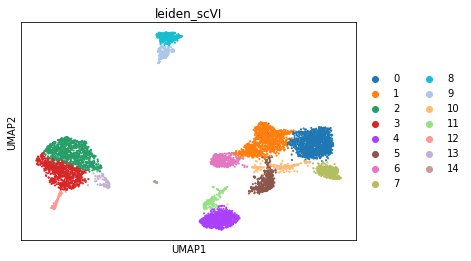

In [23]:
sc.pl.umap(adata, color=["leiden_scVI"])

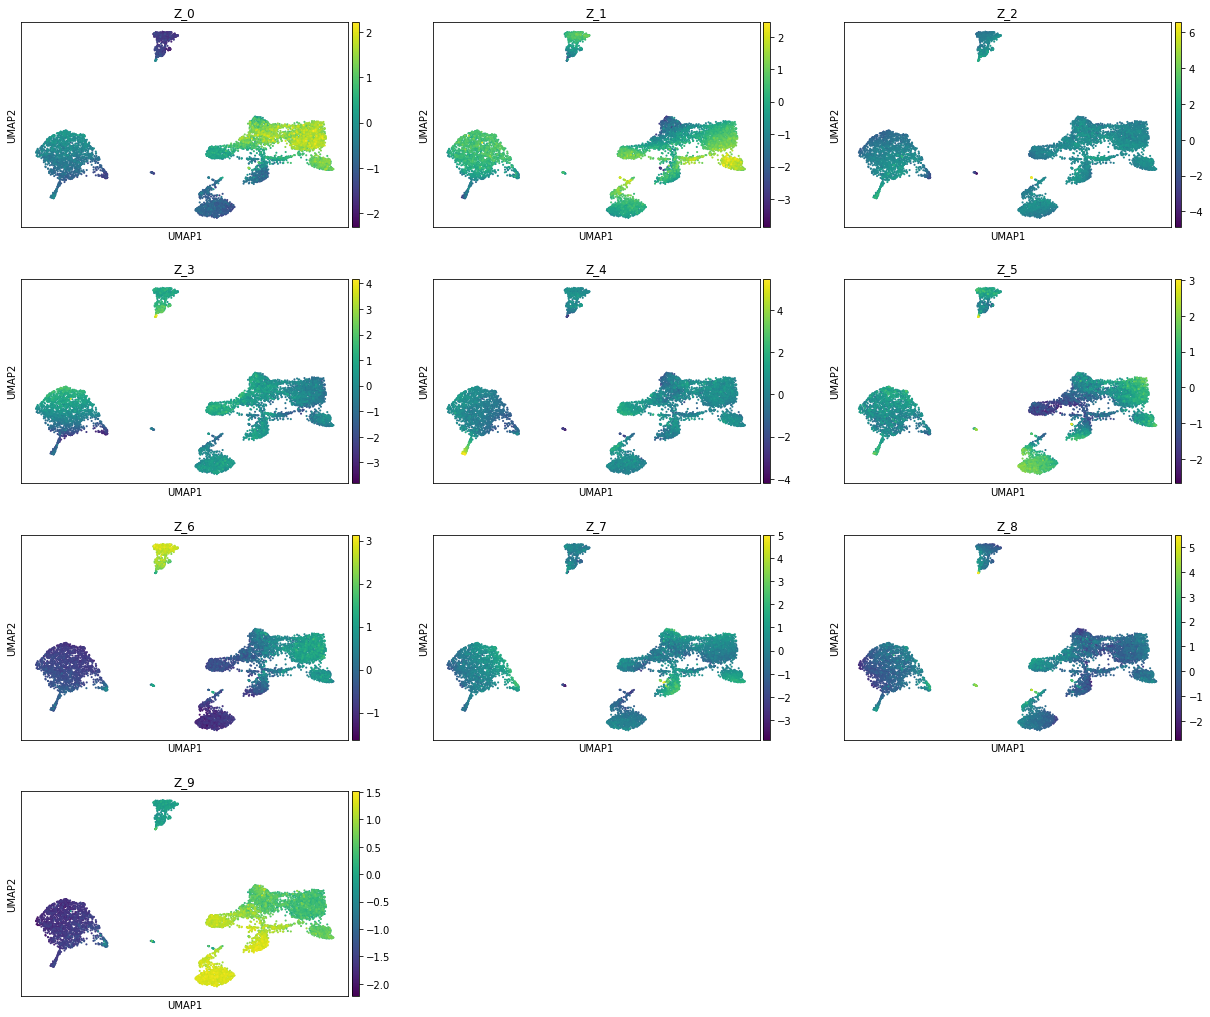

In [24]:
zs = [f'Z_{i}' for i in range(model.n_latent)]
sc.pl.umap(adata, color=zs, ncols=3)